In [212]:
## preps
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.sparse as sparse
from scipy.sparse import csr_matrix
%matplotlib inline

from sklearn.metrics import mean_squared_error

In [7]:
# Load three pre-processed datasets: reviews data, business data for selected candidate cities

## The restaurants in the five candidate cities
df_res_bus = pd.read_csv("business_data_subset.csv", index_col= None)
### reviews in the top ten candidate cities
reviews = pd.read_csv("reviews_data_subset.csv")

In [8]:
## merge the two 
df_merge = pd.merge(reviews, df_res_bus[['city','categories', 'business_id',"review_count"]], how = "outer", on ="business_id")
# df_toronto.to_csv("merged_Toronto_reviews.csv", index = None)
df_merge.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date,city,categories,review_count
0,i6g_oA9Yf9Y31qt0wibXpw,ofKDkJKXSKZXu5xJNGiiBQ,5JxlZaqCnk1MnbgRirs40Q,1.0,0.0,0.0,0.0,"Dismal, lukewarm, defrosted-tasting ""TexMex"" g...",2011-05-27 05:30:52,Las Vegas,"Restaurants, Mexican",56.0
1,Q9pkOKlRbHZy1pTUkTcBnQ,m-BZLIIh5PCAKnzH0qj_0Q,5JxlZaqCnk1MnbgRirs40Q,3.0,2.0,1.0,1.0,The three stars here don't represent a real re...,2012-06-26 07:51:00,Las Vegas,"Restaurants, Mexican",56.0
2,Y6hcNJ2bek3hSG4wm4UHKQ,PKEzKWv_FktMm2mGPjwd0Q,5JxlZaqCnk1MnbgRirs40Q,4.0,4.0,1.0,1.0,"I've been here several times, but I never revi...",2011-02-15 02:35:38,Las Vegas,"Restaurants, Mexican",56.0
3,E7Qtf8zR-e2wXFpVuaNDWQ,GdnJtqYWVSBAjya-WdN5RQ,5JxlZaqCnk1MnbgRirs40Q,2.0,2.0,0.0,0.0,I took my folks here last weekend for dinner o...,2012-05-30 18:54:30,Las Vegas,"Restaurants, Mexican",56.0
4,Q3kju7l36U0KWfuZRL_wlw,bX_VFU48rabrU_yHNL2XZg,5JxlZaqCnk1MnbgRirs40Q,4.0,0.0,0.0,0.0,"Above average in taste & presentation, which i...",2012-11-07 00:05:33,Las Vegas,"Restaurants, Mexican",56.0


## Set the city:

In [9]:
city = "Phoenix"

In [20]:
df_city_bus_ids = df_res_bus[df_res_bus["city"] == city].business_id.unique()
reviews_city = reviews[reviews["business_id"].isin(df_city_bus_ids)]
reviews_city.shape

(510982, 9)

In [21]:
df_city_res = df_merge[df_merge["city"] == city]
df_city_res.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date,city,categories,review_count
2382,UGErdm6bt48SXTVwJIti2Q,QodunSzok4nIYFNrTSGesQ,poSV39UqEg-gpESXafS9-g,3.0,0.0,0.0,0.0,My husband and I go there once a week since la...,2018-03-04 01:03:53,Phoenix,"Restaurants, American (New), Seafood, Cajun/Cr...",384.0
2383,aBWKb49Xfkv1946YN7_SIg,sSPbLBHcEMXaJfoO8zs1bA,poSV39UqEg-gpESXafS9-g,5.0,0.0,0.0,0.0,"Amazing food, drinks, service!\n\nWe started w...",2016-01-17 05:33:14,Phoenix,"Restaurants, American (New), Seafood, Cajun/Cr...",384.0
2384,jCHaWXgppmZjkOdpFltWGA,D5ywfFmwtJxLReqAYlDDmw,poSV39UqEg-gpESXafS9-g,5.0,3.0,0.0,2.0,I couldn't be more excited to have found this ...,2016-01-30 01:13:29,Phoenix,"Restaurants, American (New), Seafood, Cajun/Cr...",384.0
2385,KvJ8yT-dODmCYe21J-Pp_A,gjoN4q-f61kwjmmU4mm1_g,poSV39UqEg-gpESXafS9-g,2.0,0.0,0.0,0.0,"The craft beers are very good, but that's abou...",2016-03-30 22:28:36,Phoenix,"Restaurants, American (New), Seafood, Cajun/Cr...",384.0
2386,f88r8XKT_rPrKfyqfwRs3w,zJOGWBbq1mt3RLbKe9XgBg,poSV39UqEg-gpESXafS9-g,4.0,0.0,0.0,0.0,Great HH and awesome catfish dinner for only $...,2017-04-19 11:40:31,Phoenix,"Restaurants, American (New), Seafood, Cajun/Cr...",384.0


### The review distribution is highly skewed, with a majority of users leaving only 1 review

In [22]:
## keep restaurants with more than x reviews (x as threshold):
review_counts = reviews_city.groupby("user_id")["review_id"].count().sort_values(ascending = True)
print(review_counts.shape)
print(review_counts.describe())

(190688,)
count    190688.000000
mean          2.679676
std           6.866005
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max         590.000000
Name: review_id, dtype: float64


In [29]:
print("unique user ids:")
print(reviews_city["user_id"].nunique())
print("total reviews")
print(len(reviews_city))
print("time span:")
print(np.min(reviews_city["date"]))
print(np.max(reviews_city["date"]))

unique user ids:
190688
total reviews
510982
time span:
2005-03-08 22:19:43
2019-12-13 15:50:11


In [14]:
reviews_city.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
8,UGErdm6bt48SXTVwJIti2Q,QodunSzok4nIYFNrTSGesQ,poSV39UqEg-gpESXafS9-g,3.0,0.0,0.0,0.0,My husband and I go there once a week since la...,2018-03-04 01:03:53
12,-u8Oz_iSZACGwWW_pIT4zw,UreiTV1I9i-XF6_bJhK6Iw,d_q4avZYM1sOlQP7noJKVg,4.0,0.0,0.0,1.0,Always a fun outing to come for great hot dogs...,2018-04-15 11:13:11
19,Qee78a9rXvSfyVhCO9EK7A,NFebN50n-oXI7xgjP-Qixw,k1c_bC3DK6mKg797vH1T8w,5.0,0.0,0.0,0.0,"A very busy restaurant, make reservations, but...",2015-03-18 17:46:46
31,2E-1IudsdLlrvR6-gP51og,dZudYQD1T2U5RSJeJWYCLw,kBJfBVaXJtPEKLTov1hJdQ,5.0,1.0,1.0,0.0,When I'm Arizona...we Reathrey Sekong! \n\nFoo...,2018-03-15 19:48:59
32,jkVxX4ieJwVRO9n4E8tNMw,z8-Y3mHdujSZS7JcvzFP8A,vhKUBKcOm8zOLxeS3XM9iA,3.0,1.0,0.0,0.0,More than just Pizza. This location is small ...,2009-03-01 02:20:56


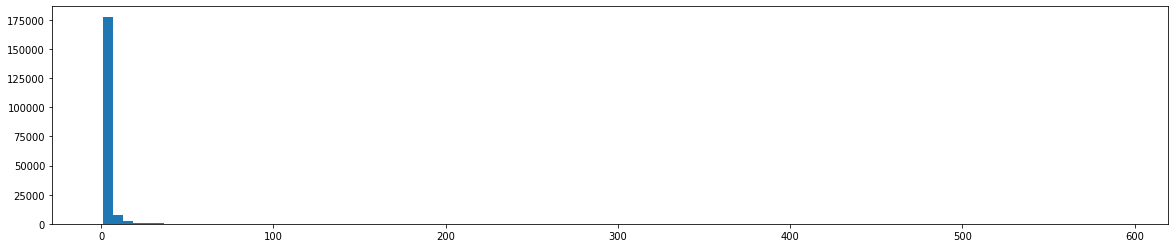

In [13]:
#### distribution highly skewed to the right
plt.figure(figsize=(20,4))
plt.hist(review_counts, bins = 100)
plt.show()

In [38]:
def getCleanReviews(reviews, min_reviews = 5):
    review_counts = reviews.groupby("user_id")["review_id"].count().sort_values()
    return reviews.loc[reviews["user_id"].isin(review_counts[review_counts >= min_reviews].index.values)]

reviews_clean = getCleanReviews(reviews_city, min_reviews=5)
print(reviews_clean.describe())
print("//")
print("number of users:")
print(reviews_clean["user_id"].nunique())


               stars         useful          funny           cool
count  262292.000000  262292.000000  262292.000000  262292.000000
mean        3.831127       1.575210       0.709004       0.956789
std         1.267949       3.683419       2.274797       3.146895
min         1.000000       0.000000       0.000000       0.000000
25%         3.000000       0.000000       0.000000       0.000000
50%         4.000000       1.000000       0.000000       0.000000
75%         5.000000       2.000000       1.000000       1.000000
max         5.000000     178.000000     169.000000     160.000000
//
number of users:
20481


In [51]:
def get_clean_df(df, min_user_review = 5, min_res_review = 1, cols = ['user_id', 'business_id', 'stars']):
    '''Cleans the df and gets rid of the unwanted cols and also allows to filter the user and business based on the min number of reviews received'''
    df_new = df[cols]
    df_new.dropna(axis = 0, how = 'any', inplace = True)
    df_new["business_freq"] = df_new.groupby(cols[1])[cols[1]].transform('count')
    df_new =  df_new[df_new['business_freq']>=min_res_review]
    df_new['user_freq'] = df_new.groupby(cols[0])[cols[0]].transform('count')
    df_new = df_new[df_new['user_freq']>=min_user_review]
    return df_new
    
def get_sparse_matrix(df):
    '''Converts the df into a sparse ratings matrix'''
    unique_users = list(df['user_id'].unique())
    unique_bus = list(df['business_id'].unique())
    data = df['stars'].tolist()
    row = pd.Series(pd.Categorical(df["user_id"],categories=unique_users)).cat.codes
    
#     df['user_id'].astype('category', categories=unique_users).cat.codes
#     col = df['business_id'].astype('category', categories=unique_bus).cat.codes
    col = pd.Series(pd.Categorical(df["business_id"], categories=unique_bus)).cat.codes
    sparse_matrix = csr_matrix((data, (row, col)), shape=(len(unique_users), len(unique_bus)))
    return sparse_matrix    

In [99]:
df_clean= get_clean_df(df_city_res,min_user_review= 20, min_res_review=20)
df_clean.shape

/Users/sigao/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/sigao/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


(111007, 5)

In [100]:
## Sparcity
df_spar_matrix = get_sparse_matrix(df_clean)
print("City:")
print(city)
print("*"*100)
print("number of unique users:")
print(df_spar_matrix.shape[0])
print("number of unique restaurants:")
print(df_spar_matrix.shape[1])
print("total reviews:")
print(df_clean.shape[0])
print("*"*100)

City:
Phoenix
****************************************************************************************************
number of unique users:
2675
number of unique restaurants:
2802
total reviews:
111007
****************************************************************************************************


In [101]:
## sparcity
sparsity_clt = 1 - df_spar_matrix.nnz/(df_spar_matrix.shape[0]*df_spar_matrix.shape[1])
sparsity_clt


0.9863313921297872

## Split test-training-validation set

In [88]:
def train_val_test_split(sparse_matrix, num_review_val = 2, num_review_test = 2):
    '''Split the rating matrix into train ,val, and test marix that are disjoint matrices'''
    nzrows, nzcols =  sparse_matrix.nonzero()
    sparse_matrix_test = csr_matrix(sparse_matrix.shape)
    sparse_matrix_val = csr_matrix(sparse_matrix.shape)
    sparse_matrix_train = sparse_matrix.copy()
    n_users = sparse_matrix.shape[0]
    for u in range(n_users):
        idx = nzcols[np.where(nzrows == u)]
        np.random.shuffle(idx)
        test_idx = idx[-num_review_test:]
        val_idx = idx[-(num_review_val+num_review_test):-num_review_test]
        train_idx = idx[:-(num_review_val+num_review_test)]
        sparse_matrix_test[u,test_idx] = sparse_matrix[u,test_idx]
        sparse_matrix_val[u,val_idx] = sparse_matrix[u,val_idx]
        sparse_matrix_train[u,test_idx] = 0
        sparse_matrix_train[u,val_idx] = 0
    data = np.array(sparse_matrix_train[sparse_matrix_train.nonzero()])[0]
    row = sparse_matrix_train.nonzero()[0]
    col = sparse_matrix_train.nonzero()[1]
    size = sparse_matrix_train.shape
    sparse_matrix_train = csr_matrix((data,(row,col)),shape = size)
    mult = sparse_matrix_train.multiply(sparse_matrix_val)
    mmult = mult.multiply(sparse_matrix_test)
    assert(mmult.nnz == 0)
    return sparse_matrix_train, sparse_matrix_val, sparse_matrix_test

In [89]:
df_train, df_val, df_test = train_val_test_split(df_spar_matrix)


/Users/sigao/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:118: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


In [14]:
sparse.save_npz("df_clt_train.csv",df_train )
sparse.save_npz("df_clt_val.csv",df_val )
sparse.save_npz("df_clt_test.csv",df_test )

In [15]:
### generate user-business matrix

In [105]:
print(df_train.nnz, df_val.nnz, df_test.nnz)

96286 5538 5538


### Modeling:

In [91]:
U_, S_, Vt_ = np.linalg.svd(df_train.todense())#k = min(sm_u_10_phx_res_train.shape)-1)

In [130]:
print("smallest singular value = ",min(S_))
print("largest singular value = ",max(S_))
S_diag = np.diag(S_)

smallest singular value =  0.5868772404360523
largest singular value =  346.8176984178511


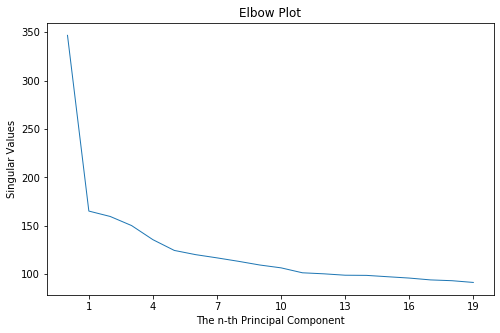

In [123]:
fig = plt.figure(figsize=(8,5))
plt.plot(S_[:20], '-', linewidth=1)
plt.title('Elbow Plot')
# plt.xticks(np.arange(0, S_phx_res.shape[0]+1, 50), rotation='vertical')
plt.xlabel('The n-th Principal Component')
plt.xticks(range(1,21,3))
plt.ylabel('Singular Values')
plt.show()

### Use SVD's top k singular values for estimation


In [128]:
def approx_err(k, A, U, S, Vt):
    rec_A = np.dot(U[:, :k], np.dot(S[:k,:k], Vt[:k, :]))
    idx = np.where(A>0);
    diff = A[idx] - rec_A[idx]
    return np.linalg.norm(diff)**2/diff.shape[1]

Text(0.5, 1.0, 'Phoenix')

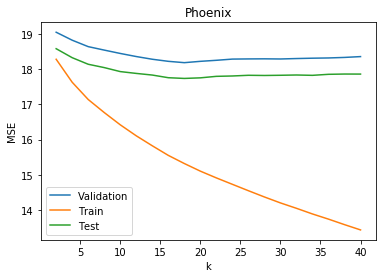

In [170]:
k = np.linspace(2,40,20, dtype = int)
errors_svd_val = {}
errors_svd_train = {}
errors_svd_test = {}
for i in k:
    errors_svd_val[i] =   approx_err(i, df_val.todense(),   U_, S_diag, Vt_)
    errors_svd_test[i] =   approx_err(i, df_test.todense(),   U_, S_diag, Vt_)
    errors_svd_train[i] = approx_err(i, df_train.todense(), U_, S_diag, Vt_)

plt.plot(k,list(errors_svd_val.values()), label = 'Validation')
plt.plot(k,list(errors_svd_train.values()), label = 'Train')
plt.plot(k,list(errors_svd_test.values()), label = 'Test')
plt.xlabel('k')
plt.ylabel('MSE')
plt.legend()
plt.title(city)

Best k
18


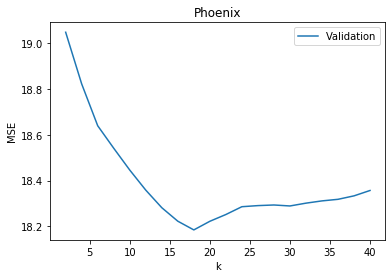

In [201]:
plt.plot(k,list(errors_svd_val.values()), label = 'Validation')
# plt.plot(k,list(errors_svd_train.values()), label = 'Train')
plt.xlabel('k')
plt.ylabel('MSE')
plt.legend()
plt.title(city)
print("Best k")
k_opt = k[np.argmin(list(errors_svd_test.values()))]
print( k_opt)


In [202]:
Best_Test_MSE_SVD = approx_err(k_opt, df_test.todense(), U_, S_diag, Vt_)
print('Best Test MSE for SVD for Restaurants in {0}= '.format(city), Best_Test_MSE_SVD)

Best Test MSE for SVD for Restaurants in Phoenix=  17.736480009244932


In [169]:
train_nnz = df_train.nonzero()
val_nnz = df_val.nonzero()
test_nnz = df_test.nonzero()

In [171]:
recon_matrix_svd =np.dot(U_[:, :k_opt], np.dot(S_diag[:k_opt,:k_opt], Vt_[:k_opt, :]))
train_preds_svd = np.ravel(recon_matrix_svd[train_nnz])
val_preds_svd = np.ravel(recon_matrix_svd[val_nnz])
test_preds_svd  = np.ravel(recon_matrix_svd[test_nnz])

### SVD with bias correction

In [181]:
def find_global_user_res_bias(ratings_matrix):
    dense_matrix = ratings_matrix.todense()
    mask_matrix = (dense_matrix>0).astype(int)
    user_bias = np.sum(dense_matrix, axis = 1)/np.sum(mask_matrix, axis = 1)
    res_bias =  np.sum(dense_matrix, axis = 0)/np.sum(mask_matrix, axis = 0)
    user_bias = np.nan_to_num(user_bias)
    res_bias = np.nan_to_num(res_bias)
    user_bias = user_bias.reshape(-1,1)
    res_bias = res_bias.reshape(1,-1)
    ratings_matrix_wo_bias = dense_matrix - np.tile(user_bias, (1,dense_matrix.shape[1]))- np.tile(res_bias, (dense_matrix.shape[0], 1))
    return user_bias, res_bias, ratings_matrix_wo_bias

In [182]:
user_bias_ur, res_bias_ur, train_ur = find_global_user_res_bias(df_train)

/Users/sigao/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


In [183]:
U_bias_ur, S_bias_ur, Vt_bias_ur = np.linalg.svd(train_ur)
print("smallest singular value = ",min(S_bias_ur))
print("largest singular value = ",max(S_bias_ur))
S_bias_ur_diag = np.diag(S_bias_ur)

smallest singular value =  0.5954441621855623
largest singular value =  26414.95531419508


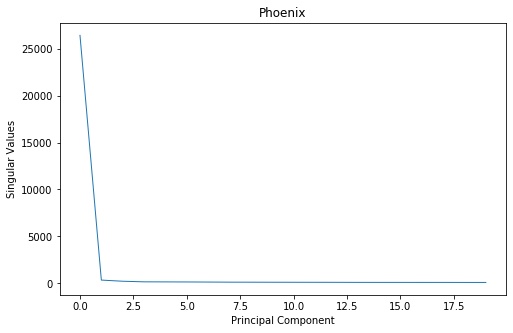

In [187]:
fig = plt.figure(figsize=(8,5))
plt.plot(S_bias_ur[:20], '-', linewidth=1)
plt.title('Elbow Plot')
plt.xlabel('Principal Component')
plt.ylabel('Singular Values')
plt.title(city)
plt.show()


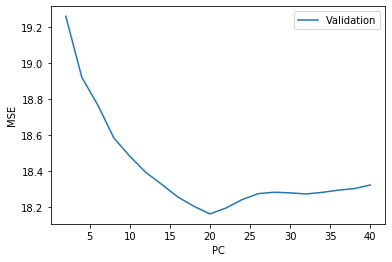

In [203]:
k_wo_bias_ur = np.linspace(2,40,20, dtype = int)
errors_svd_wo_bias_ur = {}
df_val_bias_ur = df_val.todense() - user_bias_ur - res_bias_ur

for i in k_wo_bias_ur:
    df_val_bias_ur_rec = np.dot(U_bias_ur[:, :i], np.dot(S_bias_ur_diag[:i,:i], Vt_bias_ur[:i, :]))
    idx_wo_bias_ur = np.where(df_val.todense()>0);
    diff_wo_bias_ur = df_val_bias_ur[idx_wo_bias_ur] - df_val_bias_ur_rec[idx_wo_bias_ur]
    errors_svd_wo_bias_ur[i] = np.linalg.norm(diff_wo_bias_ur)**2/diff_wo_bias_ur.shape[1]
plt.plot(k_wo_bias_ur,list(errors_svd_wo_bias_ur.values()), label= 'Validation')
plt.xlabel('PC')
plt.ylabel('MSE')
plt.legend()

In [204]:
k_opt2 = k_wo_bias_ur[np.argmin(list(errors_svd_wo_bias_ur.values()))]
print( k_opt2)

Best_Test_MSE_SVD_Bias_Cor = approx_err(k_opt2, df_test.todense(), S_bias_ur_diag, S_diag, Vt_bias_ur)
print('Best Test MSE for SVD for Restaurants in {0}= '.format(city), Best_Test_MSE_SVD)

20
Best Test MSE for SVD for Restaurants in Phoenix=  17.736480009244932


### Cosine Similarity with correction for bias

In [205]:
def similarity_matrix(train_matrix, between = 'users'):
    '''Returns the cosine similarity between users or restaurants'''
    if between == 'users':
        similarity = train_matrix*train_matrix.transpose()
    else:
        similarity = train_matrix.transpose()*train_matrix
    similarity_dense = similarity.todense() + 1e-8
    norm_array = np.sqrt(np.diag(similarity_dense))
    return similarity_dense/norm_array/norm_array.reshape(-1,1)

In [206]:
def predict_topk_nobias(ratings, similarity, kind='user', k=40):
    pred = np.zeros(ratings.shape)
    if kind == 'user':
        user_bias = np.mean(ratings, axis =1)
        ratings = (ratings - np.tile(user_bias, (ratings.shape[1],1)).T).copy()
        for i in range(ratings.shape[0]):
            top_k_users = np.argsort(similarity[:,i])[:-k-1:-1]
            pred[i] = np.dot(similarity[i,top_k_users],ratings[top_k_users,:])/np.sum(np.abs(similarity[i,top_k_users]))
        pred += np.tile(user_bias,(ratings.shape[1],1)).T
    else:
        item_bias = np.mean(ratings, axis=0)
        ratings = (ratings - np.tile(item_bias,(ratings.shape[0],1))).copy()
        for j in range(ratings.shape[1]):
            top_k_items = np.argsort(similarity[:,j])[:-k-1:-1]
            pred[:,j] = np.dot(similarity[top_k_items,j].T,ratings[:,top_k_items].T)/np.sum(np.abs(similarity[top_k_items,j]))
        pred += np.tile(item_bias,(ratings.shape[0],1))
        
    return pred

In [213]:
def get_mse(pred, actual):
    # Ignore zero terms.
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return mean_squared_error(pred, actual)

In [214]:
simi_city_res = similarity_matrix(df_train, between='res')
simi_city_res = np.array(simi_city_res)
preds_cosine = predict_topk_nobias(np.array(df_train.todense()),simi_city_res,kind='res', k=1)
MSE_cosine_res = get_mse(preds_cosine, np.array(df_val.todense()))
print("MSE for cosine Similarity between Restaurants =",MSE_cosine_res)

MSE for cosine Similarity between Restaurants = 20.570061394005055


In [219]:
train_preds_cosine= preds_cosine[train_nnz]
val_preds_cosine = preds_cosine[val_nnz]
test_preds_cosine = preds_cosine[test_nnz]

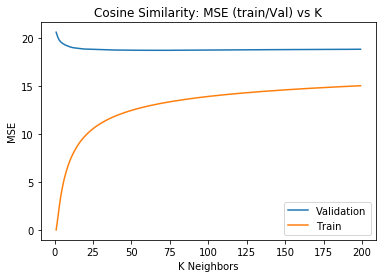

In [222]:
errors_cs_res_val = {}
errors_cs_res_train = {}
k_cs = np.arange(1, 200)
for i in k_cs:
    preds_cs_res = predict_topk_nobias(np.array(df_train.todense()),simi_city_res,kind='res', k=i)
    error_cs_val = get_mse(preds_cs_res, np.array(df_val.todense()))
    error_cs_train = get_mse(preds_cs_res, np.array(df_train.todense()))
    errors_cs_res_val[i] = error_cs_val
    errors_cs_res_train[i] = error_cs_train
plt.plot(k_cs,list(errors_cs_res_val.values()), label = 'Validation')
plt.plot(k_cs,list(errors_cs_res_train.values()), label = 'Train')
plt.xlabel('K Neighbors')
plt.ylabel('MSE')
plt.title('Cosine Similarity: MSE (train/Val) vs K')
plt.legend()

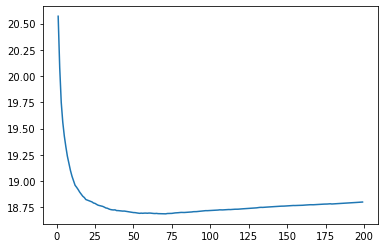

In [225]:
plt.plot(k_cs,list(errors_cs_res_val.values()), label = 'Validation')
k_opt3 = k_cs[np.argmin(list(errors_cs_res_val.values()))]

In [226]:
preds_cosine = predict_topk_nobias(np.array(df_train.todense()),simi_city_res ,kind='res', k=k_opt3)
Best_Val_MSE_Cosine = get_mse(preds_cosine, np.array(df_val.todense()))
print('Best Validation MSE for Cosine Similarity for Restaurants = ', Best_Val_MSE_Cosine)

Best Validation MSE for Cosine Similarity for Restaurants =  18.68783294234272
